В данном проекте на базе данных машин с ЮЛЫ  необходимо  обучить модель для предсказания цен на машины.

1. Создадим обучающую, тестовую и проверочную выборки. 

2. Оценим качество работы созданной сети, определив средний процент ошибки на проверочной выборке. (Для этого приведем предсказанные моделью значения к первоначальному диапазону цен.)  

3. Подсчитаем ошибку на каждом примере тестовой выборки и суммарный процент ошибки.


Рекомендации:
- в качестве ошибки рекомендуется использовать среднеквадратическую ошибку (mse).
- метрику для данной задачи можно не использовать.
- последний слой модели должен иметь 1 нейрон.
- суммарный процент ошибки = средний модуль ошибки (MAE) / среднюю цену машины. Например, если средняя цена машины 560.000 р, а средняя ошибка 56.000р, то процент ошибки равен 10%.


In [184]:
# Работа с массивами данных
import numpy as np 

# Работа с табличными данными
import pandas as pd

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [185]:
# Загрузка датафрейма из google облака
gdown.download('https://storage.googleapis.com/datasets_ai/Base/10_regression/cars_new.csv', None, quiet=True)

'cars_new.csv'

In [186]:
df = pd.read_csv('cars_new.csv', encoding= 'utf_8', header=0, index_col=0) # Загружаем базу
display(df.head())

,model,price,year,mileage,body,kpp,fuel,volume,power
mark,,,,,,,,,
kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0


In [187]:
df.reset_index(level=0, inplace=True)

In [188]:
df

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0
...,...,...,...,...,...,...,...,...,...,...
70114,skoda,fabia 5j [рестайлинг],310000,2011,165000,хетчбэк,механика,бензин,1.2,70.0
70115,ford,focus 3 поколение,400000,2011,125000,хетчбэк,механика,бензин,1.6,105.0
70116,mazda,cx-5 1 поколение,1140000,2013,89981,кроссовер,автомат,бензин,2.0,150.0
70117,toyota,bb 2 поколение,550550,2006,183000,минивэн,автомат,бензин,1.3,92.0


In [189]:
df.shape

(70119, 10)

Итак, у нас в таблице 9 колонок, 70119 записей. Посмотрим на типы данных, количество пропусков и распределение. Решим, нужно ли избавляться от выбросов, удалять пропуски, приводить данные к нужному формату

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70119 entries, 0 to 70118
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mark     70119 non-null  object 
 1   model    70119 non-null  object 
 2   price    70119 non-null  int64  
 3   year     70119 non-null  int64  
 4   mileage  70119 non-null  int64  
 5   body     70116 non-null  object 
 6   kpp      70115 non-null  object 
 7   fuel     70119 non-null  object 
 8   volume   70119 non-null  float64
 9   power    70119 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 5.3+ MB


Все типы данных соответствуют, пока не будем переводить одни типы данных в другие

In [191]:
# посмотрим на распределение данных
df.describe()

,price,year,mileage,volume,power
count,7.011900e+04,70119.000000,70119.000000,70119.000000,70119.000000
mean,5.277261e+05,2007.228668,162237.510988,1.917526,136.473381
std,6.236842e+05,7.086385,95872.148255,0.671154,59.054250
min,1.600000e+04,1949.000000,1.000000,0.300000,11.000000
25%,2.050000e+05,2004.000000,96980.000000,1.600000,102.000000
50%,3.800000e+05,2008.000000,147000.000000,1.800000,123.000000
75%,6.400000e+05,2012.000000,210000.000000,2.000000,152.000000
max,2.450000e+07,2019.000000,999999.000000,10.000000,1400.000000


Прекрасные данные. Видно, что в количественных столбцах не имеется пропусков, данные распределены очень реалистично, без явных выбросов. Единственное, что вызывает вопросы-данные по объему двигателя - в нашей табличке максимум - это 10 л. Интересно, что это за суперкар такой? Давайте-ка проверим:

In [192]:
df.query('volume >8')

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
11810,chevrolet,lanos 1 поколение,80000,2008,90000,седан,механика,бензин,10.0,63.0
15149,mercedes-benz,vito w638,450000,2002,250000,минивэн,автомат,дизель,10.0,150.0
53455,volkswagen,multivan t5 [рестайлинг],1750000,2012,152000,минивэн,робот,дизель,10.0,260.0
57429,chevrolet,suburban gmt800,750000,2005,329000,внедорожник,автомат,бензин,8.1,320.0
58092,toyota,rav4,450000,2003,177000,кроссовер,автомат,бензин,9.0,51.0


И действительно - 5 записей в нашем датафрейме имеют обьем двигателя более 8 литров. У модели suburban gmt800	действительно указанный объем двигателя соответствует реальности. Остальные предлагаю удалить как выбросы

In [193]:
df=df.query('volume <9')

In [194]:
# посмотрим на количество пропусков в датафрейме:
df.isna().sum()

mark       0
model      0
price      0
year       0
mileage    0
body       3
kpp        4
fuel       0
volume     0
power      0
dtype: int64

В колонках body и kpp имеются суммарно 7 пропусков. Удалим их без сожалений, так как их всего 7. Было бы больше - можно было бы заморочиться и на что-то их заменить.

In [195]:
df=df.dropna()

In [196]:
# проверим, все ли удалилось
df.isna().sum()

mark       0
model      0
price      0
year       0
mileage    0
body       0
kpp        0
fuel       0
volume     0
power      0
dtype: int64

In [197]:
# проверим, имеются ли дубликаты в таблице
df.duplicated().sum()

0

In [198]:
df.head()

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0


In [199]:
#Посмотрим, сколько уникальных значений мы имеем в категориальных признаках и каких:
cat_features = ["mark", "year", "body", "kpp", "fuel"]
df[cat_features].nunique()

mark    21
year    52
body    16
kpp      4
fuel     5
dtype: int64

In [200]:
print('Уникальные значения моделей', df['mark'].unique())
print()
print('Уникальные значения корпуса', df['body'].unique())
print()
print('Уникальные значения коробки передач', df['kpp'].unique())
print()
print('Уникальные значения топлива', df['fuel'].unique())

Уникальные значения моделей ['kia' 'daewoo' 'suzuki' 'bmw' 'chevrolet' 'hyundai' 'toyota'
 'mercedes-benz' 'chery' 'ford' 'mazda' 'peugeot' 'volkswagen' 'audi'
 'mitsubishi' 'opel' 'nissan' 'skoda' 'subaru' 'honda' 'renault']

Уникальные значения корпуса ['седан' 'внедорожник' 'кроссовер' 'хетчбэк' 'универсал' 'минивэн'
 'лифтбэк' 'купе' 'микроавтобус' 'пикап' 'кабриолет' 'хардтоп' 'родстер'
 'тарга' 'лимузин' 'фастбэк']

Уникальные значения коробки передач ['автомат' 'механика' 'робот' 'вариатор']

Уникальные значения топлива ['бензин' 'дизель' 'гибрид' 'электро' 'газ']


In [201]:
# посмотрим на распределение подкатегорий в столбцах нашей таблицы
for col in df.columns:
    print(col)
    print(df[col].value_counts(normalize=True)*100)
    print('\n')

mark
toyota           5.765391
mercedes-benz    5.749700
ford             5.746848
opel             5.738289
mitsubishi       5.736863
bmw              5.732584
chevrolet        5.702630
volkswagen       5.696925
nissan           5.688367
hyundai          5.669824
kia              5.644149
renault          5.607063
audi             5.391681
mazda            5.377418
daewoo           4.649969
skoda            4.179266
honda            3.605865
peugeot          3.090945
suzuki           1.882809
chery            1.720203
subaru           1.623210
Name: mark, dtype: float64


model
matiz m150 [рестайлинг]               1.514806
focus 3 поколение                     1.178182
nexia 1 поколение [2-й рестайлинг]    1.156787
nexia 1 поколение [рестайлинг]        1.044103
lacetti 1 поколение                   0.891482
                                        ...   
5 серия f07/f10/f11                   0.001426
baja 1 поколение                      0.001426
eclipse 1g [рестайлинг]               

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


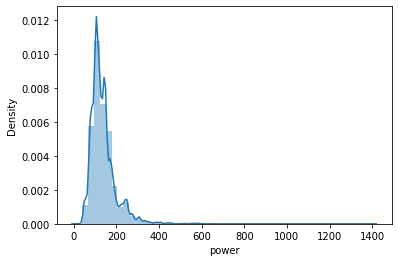

In [202]:
# Посмотрим на графики распределения числовых признаков в колонках  price, power, mileage, чтобы понять, имеются ли выбросы:
import seaborn as sns
sns_plot = sns.distplot(df["power"])
fig = sns_plot.get_figure()

В нашем датафрейме имеются очень мощные автомобили - более 1400 л.с. Звучит невероятно. Давайте-ка посмотрим на этих гигантов:

In [203]:
df.query("power > 1200")

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
5603,opel,astra,469000,2011,122000,хетчбэк,автомат,бензин,1.4,1400.0
27771,mitsubishi,asx 1 поколение [рестайлинг],746000,2013,97000,кроссовер,вариатор,бензин,1.8,1400.0


In [204]:
df['power'].mean()

136.47496719347293

Объем двигателя Мицубиси АСХ составляет от 1.6 до 2.0 л. Мощность двигателей Mitsubishi ASX от 117 до 150 л. с.
Объем двигателя Опель Астра составляет от 1.0 до 2.2 л. Мощность двигателей Opel Astra от 60 до 200 л. с.
Видимо, тут кто-то явно ошибся ноликом. Исправим ошибку:

In [205]:
df.loc[df['power'] >1200, 'power'] = 140

In [206]:
# проверим, правильно ли все заменилось:
df.query("power > 1200")

,mark,model,price,year,mileage,body,kpp,fuel,volume,power


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


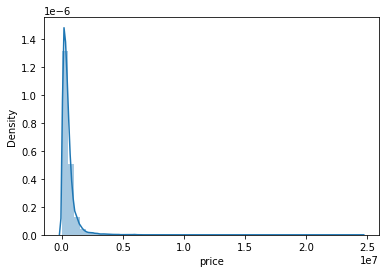

In [207]:
sns_plot = sns.distplot(df["price"])
fig = sns_plot.get_figure()

In [208]:
df.query('price>2000000')

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
100,mercedes-benz,gle-класс 350 w166/c292,3049000,2016,25784,кроссовер,автомат,дизель,3.0,249.0
118,bmw,x5 30 f15,2330000,2014,100338,кроссовер,автомат,дизель,3.0,249.0
170,mercedes-benz,gl-класс 350 x166,3000000,2015,130000,внедорожник,автомат,дизель,3.0,258.0
179,mercedes-benz,v-класс w447 [рестайлинг],9650000,2017,30057,минивэн,автомат,дизель,2.1,190.0
217,mercedes-benz,g-класс 350 w463 [2-й рестайлинг],3550000,2013,89432,внедорожник,автомат,дизель,3.0,211.0
...,...,...,...,...,...,...,...,...,...,...
69962,mercedes-benz,s-класс amg w222/c217/a217,5300000,2015,67588,купе,автомат,бензин,5.5,585.0
69964,bmw,5 серия 520,2149000,2017,33062,седан,автомат,дизель,2.0,190.0
70017,toyota,land cruiser 200 j200 [2-й рестайлинг],3980000,2016,53263,внедорожник,автомат,дизель,4.5,249.0
70048,audi,q7 4l [рестайлинг],2189000,2015,55409,кроссовер,автомат,дизель,3.0,245.0


В нашем датафрейме есть 1630 записей об автомобилях стоимостью более 2 млн рублей. На вскидку, поглядев на марки автомобилей - среди них, действительно, дорогие марки, такие как mercedes-benz, bmw, audi. Основная же масса записей лежит в пределах от 0 до примерно 250 000 рублей. Звучит реалистично, удалять не будем.

In [209]:
#На всякий случай проверим, есть ли нулевые значения в колонке с ценой
df.query('price==0')

,mark,model,price,year,mileage,body,kpp,fuel,volume,power


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


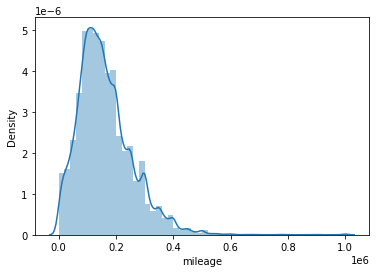

In [210]:
sns_plot = sns.distplot(df["mileage"])
fig = sns_plot.get_figure()

Основная масса значений лежит в пределах от 0 до примерно 600 000 км. К данной колонке вопросов нет, так что продолжим.
Посмотрим на корреляцию колонок по отношению к ключевому признаку (к колонке Price).

In [211]:
correlations_data = df.corr()['price'].sort_values()
correlations_data

mileage   -0.378400
volume     0.399831
year       0.478208
power      0.561377
price      1.000000
Name: price, dtype: float64

Значения коэффициента корреляции интерпретируются следующим образом:

До 0,2 — очень слабая корреляция До 0,5 — слабая До 0,7 — средняя До 0,9 — высокая Больше 0,9 — очень высокая И действительно, корреляцию (0.56) можно наблюдать между столбцами "power" и "price", корреляцию 0.47 между столбцами Price и year, корреляцию 0.39 можно увидеть между колонками volume и price. Также имеется отрицательная корреляция между колонками mileage и price - то есть, чем больше пробег, тем ниже цена.

Итак, насколько нам позволяет датасет и само задание, мы избавились от выбросов (аномальных значений) и пропусков. Приступим к кодированию категориальных и масштабирование численных признаков.

Для начала извлечем текстовые данные из колонки model таблицы, помещаем в переменную data_text. Выводим длину списка:

In [212]:
data_text = df['model'].values #

len(data_text)

70108

In [213]:
# укажем размер словаря, инициализируем Токенайзер с соотв. параметрами, обработаем им нашу переменную data_text
maxWordsCount = 5000 

sim_for_del='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer (num_words=maxWordsCount, 
                       filters=sim_for_del, 
                       lower=True, 
                       split=' ', 
                       oov_token='unknown', 
                       char_level=False)

tokenizer.fit_on_texts(data_text)

In [214]:
# Переводим в Эмбеддинг пространство
Sequences = tokenizer.texts_to_sequences(data_text)

# Вариант  Bag of Words
xBOW_text = tokenizer.sequences_to_matrix(Sequences)

Напишем функцию purify() для очистки текста в таблице с данными. Она убирает из строки следующие символы:
\n;
\xa0;
пробелы по краям.
А также приведет все символы к нижнему регистру.

In [215]:
def purify(x):
    if isinstance(x, str):                # Если значение - строка:
        # Замена концов строк на пробелы, удаление символа с кодом 0xA0,
        # обрезка краевых пробелов и приведение к нижнему регистру
        x = x.replace('\n', ' ').replace('\xa0', '').strip().lower()
    return x

In [216]:
df.head(20)

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0
5,hyundai,creta 1 поколение,985000,2016,34067,кроссовер,автомат,бензин,2.0,150.0
6,kia,ceed 2 поколение,589000,2013,98000,хетчбэк,автомат,бензин,1.6,129.0
7,toyota,corolla e140,500000,2008,141000,седан,автомат,бензин,1.6,124.0
8,mercedes-benz,c-класс 180 w204/s204/c204 [рестайлинг],1320000,2015,81112,седан,автомат,бензин,1.6,156.0
9,bmw,7 серия 735 e65/e66,270000,2001,300000,седан,автомат,бензин,3.6,272.0


In [217]:
df['model'].nunique()

3156

признак "model", из-за того, что там 3156 уникальных значений, закодируем техникой OrdinalEncoder.

In [218]:
data =pd.concat([pd.get_dummies(df.drop(["model"], axis=1), drop_first=True), df["model"]], axis=1)

In [219]:
#Разобьем данные на признаки и целевой столбец:
features = data.drop(['price'], axis=1)
target = data["price"]

In [220]:
# Воспользуемся функцией train_test_split, чтобы разделить нашу таблицу на 3 выборки: обучающую, тестовую и валидационную. 
# Разделим наш датафрейм стачала на обучающую и  валидационную, 
# после этого еще раз поделим валидационную на валидационную и тестовую

df_train, df_valid = train_test_split(data, test_size=0.25, random_state=12345)
df_valid, df_test = train_test_split(df_valid,test_size = 0.5, random_state=12345)
print('Размер обучающей выборки:', df_train.shape[0],'записей')
print('Размер тестовой выборки:',df_test.shape[0],'записей')
print('Размер валидационной выборки:', df_valid.shape[0],'записей')

Размер обучающей выборки: 52581 записей
Размер тестовой выборки: 8764 записей
Размер валидационной выборки: 8763 записей


In [221]:
#Валидационная выборка
valid_features = df_valid.drop(['price'], axis=1)
valid_target = df_valid['price']

#Обучающая выборка
train_features = df_train.drop(['price'], axis=1, inplace=False)
train_target = df_train['price']

#Тестовая выборка
test_features = df_test.drop(['price'], axis=1)
test_target = df_test['price']

In [222]:
# выделим колонки с числовыми данными для масштабирования
numeric = ['power','mileage']

In [223]:
# Инициализируем StandardScaler для масштабирования колонок 'power' и 'mileage':
scaler = StandardScaler()

In [224]:
# к тренировочным признакам применим fit и transform, а к валидационным и тестовым - только transform
scaler.fit(train_features[numeric])

train_features_scal = train_features.copy()
valid_features_scal = valid_features.copy()
test_features_scal = test_features.copy()

In [225]:
train_features_scal[numeric] = scaler.fit_transform(train_features[numeric])
valid_features_scal[numeric]= scaler.transform(valid_features[numeric])
test_features_scal[numeric]= scaler.transform(test_features[numeric])

In [226]:
train_features_scal.head()

,year,mileage,volume,power,mark_bmw,mark_chery,mark_chevrolet,mark_daewoo,mark_ford,mark_honda,mark_hyundai,mark_kia,mark_mazda,mark_mercedes-benz,mark_mitsubishi,mark_nissan,mark_opel,mark_peugeot,mark_renault,mark_skoda,mark_subaru,mark_suzuki,mark_toyota,mark_volkswagen,body_кабриолет,body_кроссовер,body_купе,body_лимузин,body_лифтбэк,body_микроавтобус,body_минивэн,body_пикап,body_родстер,body_седан,body_тарга,body_универсал,body_фастбэк,body_хардтоп,body_хетчбэк,kpp_вариатор,kpp_механика,kpp_робот,fuel_газ,fuel_гибрид,fuel_дизель,fuel_электро,model
47709,2012,-0.740682,1.8,0.808596,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,c-класс 200 w204/s204/c204 [рестайлинг]
28209,1991,1.570606,2.0,0.484881,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,vigor cb5
47235,2017,-1.355720,1.6,-0.929244,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,logan 2 поколение
26232,2008,-0.699640,2.3,1.728630,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,cx-7 1 поколение
13627,2005,-0.689226,1.6,-0.656642,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,lancer ix


In [227]:
encoder = OrdinalEncoder()

In [228]:
colums_for_encoding=valid_features_scal["model"]
valid_features_scal["model_OE"]=encoder.fit_transform(colums_for_encoding.values.reshape(-1, 1))

In [229]:
colums_for_encoding=train_features_scal["model"]
train_features_scal["model_OE"]=encoder.fit_transform(colums_for_encoding.values.reshape(-1, 1))

In [230]:
colums_for_encoding=test_features_scal["model"]
test_features_scal["model_OE"]=encoder.fit_transform(colums_for_encoding.values.reshape(-1, 1))

In [231]:
train_features_scal1=train_features_scal.drop(['model'], axis=1, inplace=False)
train_features_scal1

,year,mileage,volume,power,mark_bmw,mark_chery,mark_chevrolet,mark_daewoo,mark_ford,mark_honda,mark_hyundai,mark_kia,mark_mazda,mark_mercedes-benz,mark_mitsubishi,mark_nissan,mark_opel,mark_peugeot,mark_renault,mark_skoda,mark_subaru,mark_suzuki,mark_toyota,mark_volkswagen,body_кабриолет,body_кроссовер,body_купе,body_лимузин,body_лифтбэк,body_микроавтобус,body_минивэн,body_пикап,body_родстер,body_седан,body_тарга,body_универсал,body_фастбэк,body_хардтоп,body_хетчбэк,kpp_вариатор,kpp_механика,kpp_робот,fuel_газ,fuel_гибрид,fuel_дизель,fuel_электро,model_OE
47709,2012,-0.740682,1.8,0.808596,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,649.0
28209,1991,1.570606,2.0,0.484881,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,2761.0
47235,2017,-1.355720,1.6,-0.929244,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1774.0
26232,2008,-0.699640,2.3,1.728630,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1033.0
13627,2005,-0.689226,1.6,-0.656642,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1691.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47879,2007,-0.803780,2.0,0.570069,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,392.0
16934,2018,-1.683761,1.4,0.058940,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,778.0
28009,2011,-0.559510,2.4,0.570069,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,164.0
4095,2008,-0.008153,1.5,-0.588491,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,425.0


In [232]:
valid_features_scal1=valid_features_scal.drop(['model'], axis=1, inplace=False)
test_features_scal1=test_features_scal.drop(['model'], axis=1, inplace=False)

In [233]:
def plot_history(history):
    plt.plot(history.history['mae'], 
            label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(history.history['val_mae'], 
            label='Средняя абсолютная ошибка на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.legend()
    plt.show()

Epoch 1/120
175/175 [==============================] - 2s 9ms/step - loss: 660024721408.0000 - mae: 527556.3125 - val_loss: 657318281216.0000 - val_mae: 520447.0625
Epoch 2/120
175/175 [==============================] - 1s 7ms/step - loss: 653999603712.0000 - mae: 521920.2500 - val_loss: 647183990784.0000 - val_mae: 510624.0000
Epoch 3/120
175/175 [==============================] - 1s 6ms/step - loss: 638848860160.0000 - mae: 507142.6250 - val_loss: 627271729152.0000 - val_mae: 490888.7812
Epoch 4/120
175/175 [==============================] - 1s 7ms/step - loss: 613330059264.0000 - mae: 481777.6562 - val_loss: 596767080448.0000 - val_mae: 460150.0625
Epoch 5/120
175/175 [==============================] - 1s 7ms/step - loss: 577807253504.0000 - mae: 446751.9688 - val_loss: 557402619904.0000 - val_mae: 421357.1562
Epoch 6/120
175/175 [==============================] - 1s 6ms/step - loss: 535031087104.0000 - mae: 406656.9688 - val_loss: 513162674176.0000 - val_mae: 380896.4375
Epoch 7/12

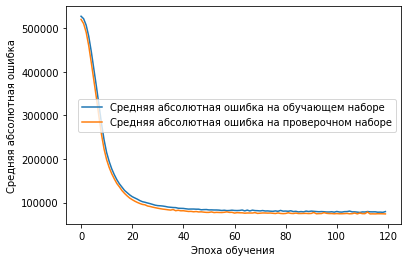

In [234]:
# Обучение модели на простых данных

model_simple = Sequential()
model_simple.add(BatchNormalization(input_dim=train_features_scal1.shape[1]))
model_simple.add(Dense(128, activation='relu'))
model_simple.add(Dense(1000, activation='tanh'))
model_simple.add(Dense(500, activation='relu'))
model_simple.add(Dense(100, activation='relu'))
model_simple.add(Dense(1, activation='linear'))

model_simple.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

history = model_simple.fit(train_features_scal1, 
                    train_target, 
                    epochs=120, 
                    batch_size=256,
                    validation_split=0.15, 
                    verbose=1)

plot_history(history)

In [235]:
from sklearn.metrics import mean_squared_error
# Проверка работы сети - предсказание на тренировочной выборке
pred = model_simple.predict(train_features_scal1)

# Расчет среднего значения ошибки 
#print((abs(pred - train_target)).mean())         # Расчет вручную
print('MAE', mean_absolute_error(pred, train_target))   # Расчет с помощью готовой функции
print('MSE', mean_squared_error(pred, train_target))   # Расчет с помощью готовой функции
print('RMSE', mean_squared_error(pred, train_target, squared=False))   # Расчет с помощью готовой функции

MAE 72605.10349850112
MSE 36735323389.22848
RMSE 191664.6117290004


Ошибка в 72 000 рублей.

в задании указано сдедующее: необходимо посчитать суммарный процент ошибки = средний модуль ошибки (MAE) / среднюю цену машины. Например, если средняя цена машины 560.000 р, а средняя ошибка 56.000р, то процент ошибки равен 10%.

In [236]:
pred_test = model_simple.predict(test_features_scal1)

In [237]:
# Расчет среднего значения ошибки 
#print((abs(pred_test - test_target)).mean())         # Расчет вручную
print('MAE', mean_absolute_error(pred_test, test_target))   # Расчет с помощью готовой функции
print('MSE', mean_squared_error(pred_test, test_target))   # Расчет с помощью готовой функции
print('RMSE', mean_squared_error(pred_test, test_target, squared=False))   # Расчет с помощью готовой функции

MAE 80934.7477433428
MSE 47496788498.63393
RMSE 217937.57936306883


In [238]:
# считаю среднюю цену машины на тестовой выборке
test_price_mean=test_target.mean()

In [239]:
# считаю суммарный процент ошибки = средний модуль ошибки (MAE) / среднюю цену машины.
result=(mean_absolute_error(pred_test, test_target))/test_price_mean
result

0.15226572012792086

Итак, мы получили суммарный процент ошибки=15%. Посмотрим, удастся нам уменьшить этот показатель, если мы нормируем цену

In [240]:
train_target

47709     860000
28209     115000
47235     440000
26232     545000
13627     290000
          ...   
47879     520000
16934    1339800
28009     649000
4095      229000
2178      570000
Name: price, Length: 52581, dtype: int64

In [241]:
# Нормализация выходных данных по стандартному нормальному распределению
train_target_scaled = scaler.fit_transform(train_target.to_numpy().reshape(-1, 1))

In [242]:
valid_target_scaled = scaler.fit_transform(valid_target.to_numpy().reshape(-1, 1))
test_target_scaled = scaler.fit_transform(test_target.to_numpy().reshape(-1, 1))

Epoch 1/200
175/175 [==============================] - 2s 8ms/step - loss: 0.3074 - mae: 0.2357 - val_loss: 174.7602 - val_mae: 13.2034
Epoch 2/200
175/175 [==============================] - 1s 7ms/step - loss: 0.1819 - mae: 0.1764 - val_loss: 34.1336 - val_mae: 5.5467
Epoch 3/200
175/175 [==============================] - 1s 7ms/step - loss: 0.1524 - mae: 0.1657 - val_loss: 0.9949 - val_mae: 0.7711
Epoch 4/200
175/175 [==============================] - 1s 7ms/step - loss: 0.1418 - mae: 0.1590 - val_loss: 0.1844 - val_mae: 0.1772
Epoch 5/200
175/175 [==============================] - 1s 7ms/step - loss: 0.1320 - mae: 0.1524 - val_loss: 0.1562 - val_mae: 0.1416
Epoch 6/200
175/175 [==============================] - 1s 7ms/step - loss: 0.1224 - mae: 0.1464 - val_loss: 0.1586 - val_mae: 0.1382
Epoch 7/200
175/175 [==============================] - 1s 6ms/step - loss: 0.1229 - mae: 0.1543 - val_loss: 0.1767 - val_mae: 0.1771
Epoch 8/200
175/175 [==============================] - 1s 7ms/ste

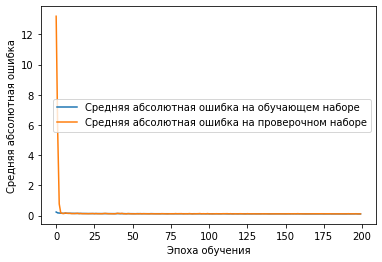

In [243]:
# Обучение модели на простых данных

model_simple_scaled = Sequential()
model_simple_scaled.add(BatchNormalization(input_dim=train_features_scal1.shape[1]))
model_simple_scaled.add(Dense(128, activation='relu'))
model_simple_scaled.add(Dense(1000, activation='tanh'))
model_simple_scaled.add(Dense(500, activation='relu'))
model_simple_scaled.add(Dense(100, activation='relu'))
model_simple_scaled.add(Dense(1, activation='linear'))

model_simple_scaled.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

history = model_simple_scaled.fit(train_features_scal1, 
                    train_target_scaled, 
                    epochs=200, 
                    batch_size=256,
                    validation_split=0.15, 
                    verbose=1)

plot_history(history)

In [244]:
pred_test_scaled = model_simple_scaled.predict(test_features_scal1)

In [245]:
# Расчет среднего значения ошибки 
#print((abs(pred_test - test_target)).mean())         # Расчет вручную
print('MAE', mean_absolute_error(pred_test_scaled, test_target_scaled))   # Расчет с помощью готовой функции
print('MSE', mean_squared_error(pred_test_scaled, test_target_scaled))   # Расчет с помощью готовой функции
print('RMSE', mean_squared_error(pred_test_scaled, test_target_scaled, squared=False))   # Расчет с помощью готовой функции

MAE 0.1343324196342049
MSE 0.07180131189755473
RMSE 0.2679576681073985


In [246]:
# Функция оценки результатов и вывода оценки

def eval_net(model, x_train, y_train, y_scaler = None, n = 10, limit = 1000.):
  
    pred = model.predict(x_train)             # Предсказание на тренировочной выборке
    if y_scaler:                              # Если есть нормирование - то денормировать
        pred = y_scaler.inverse_transform(pred)

    print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y_train), '\n')

    for i in range(n):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(y_train[i, 0],
                                                                                                    pred[i, 0],
                                                                                                    abs(y_train[i, 0] - pred[i, 0])))
    # Построение картинки разброса предсказанных и верных значений зарплаты
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_train, pred)                 # Отрисовка точечного графика
    ax.set_xlim(0, limit)                     # Пределы по x, y
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')      # Отрисовка диагональной линии
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()        

In [247]:
train_target_np = train_target.to_numpy().reshape(-1, 1)

In [248]:
train_target

47709     860000
28209     115000
47235     440000
26232     545000
13627     290000
          ...   
47879     520000
16934    1339800
28009     649000
4095      229000
2178      570000
Name: price, Length: 52581, dtype: int64

Средняя абсолютная ошибка: 64085.16246561016 

Реальное значение: 860000.00  Предсказанное значение: 1012710.88  Разница: 152710.88
Реальное значение: 115000.00  Предсказанное значение: 108462.64  Разница: 6537.36
Реальное значение: 440000.00  Предсказанное значение: 514614.75  Разница: 74614.75
Реальное значение: 545000.00  Предсказанное значение: 510225.50  Разница: 34774.50
Реальное значение: 290000.00  Предсказанное значение: 204378.45  Разница: 85621.55
Реальное значение: 564999.00  Предсказанное значение: 570343.25  Разница: 5344.25
Реальное значение: 649000.00  Предсказанное значение: 607869.38  Разница: 41130.62
Реальное значение: 235000.00  Предсказанное значение: 250391.70  Разница: 15391.70
Реальное значение: 410000.00  Предсказанное значение: 341491.91  Разница: 68508.09
Реальное значение: 190000.00  Предсказанное значение: 215165.27  Разница: 25165.27


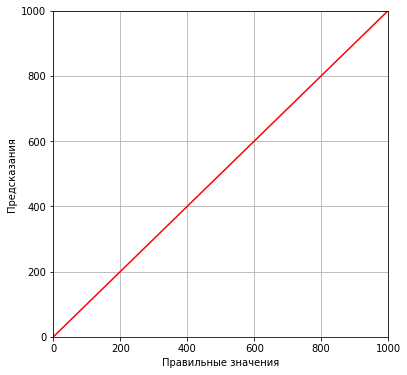

In [249]:
eval_net(model_simple_scaled, train_features_scal1, train_target_np, scaler)

In [250]:
# считаю среднюю цену машины на тестовой выборке
test_price_scaled_mean=test_target_scaled.mean()

In [251]:
MAE_scaled=mean_absolute_error(pred_test_scaled, test_target_scaled)
MAE_scaled

0.1343324196342049

In [252]:
pred_unscaled = scaler.inverse_transform(pred_test_scaled)

In [253]:
MAE_unscaled=mean_absolute_error(pred_unscaled, test_target)
MAE_unscaled

86629.44019571476

In [254]:
# считаю суммарный процент ошибки = средний модуль ошибки (MAE) / среднюю цену машины.
result_unscaled=MAE_unscaled/test_price_mean
result_unscaled

0.16297936873182073

Получается, в нашем случае нормализация целевого столбца "price" отрицательно сказалась на эффективности модели.

Попробуем обработать значения из текстового столбца "model', извлекая от туда данные по рестайлингу, названию модели и номер поколения, серии - в общем, из всего, что можно извлечь из этой колонки, сделаем бинарные колонки в нашей табличке. К сожалению, я не нашла, как автоматизировать следующие действия, по этому код получился длинноват... затем запустим модель на обновленных данных и посмотрим, удалось ли улучшить результативность

In [255]:
train_features_scal['model']

47709    c-класс 200 w204/s204/c204 [рестайлинг]
28209                                  vigor cb5
47235                          logan 2 поколение
26232                           cx-7 1 поколение
13627                                  lancer ix
                          ...                   
47879                                      a4 b7
16934                           ceed 3 поколение
28009                           4007 1 поколение
4095                                   accent lc
2178                           3 bl [рестайлинг]
Name: model, Length: 52581, dtype: object

In [256]:
def rest(x):
  x['restyle']=x['model'].str.contains('рестайлинг')
  x.loc[x['restyle'] == True, 'restyle'] = 1
  x.loc[x['restyle'] == False, 'restyle'] = 0

In [257]:
rest(train_features_scal)
rest(valid_features_scal)
rest(test_features_scal)

In [258]:
def rest2(x):
  x['restyle2']=x['model'].str.contains('2-й рестайлинг')
  x.loc[x['restyle2'] == True, 'restyle2'] = 1
  x.loc[x['restyle2'] == False, 'restyle2'] = 0

In [259]:
rest2(train_features_scal)
rest2(valid_features_scal)
rest2(test_features_scal)

In [260]:
def rest3(x):
  x['restyle3']=x['model'].str.contains('3-й рестайлинг')
  x.loc[x['restyle3'] == True, 'restyle3'] = 1
  x.loc[x['restyle3'] == False, 'restyle3'] = 0

In [261]:
rest3(train_features_scal)
rest3(valid_features_scal)
rest3(test_features_scal)

К сожалению, я пока не нашла, как сократить дальнейшие действия, по этому по очереди применяю функцию, создавая новый столбец с данными по каждому поколению из столбца model...

если подскажете, как это можно было бы автоматизировать - была бы очень признательна


In [262]:
def generation_1(x):
  x['generation_1']=x['model'].str.contains('1 поколение')
  x.loc[x['generation_1'] == True, 'generation_1'] = 1
  x.loc[x['generation_1'] == False, 'generation_1'] = 0

In [263]:
generation_1(train_features_scal)
generation_1(valid_features_scal)
generation_1(test_features_scal)

In [264]:
def generation_2(x):
  x['generation_2']=x['model'].str.contains('2 поколение')
  x.loc[x['generation_2'] == True, 'generation_2'] = 1
  x.loc[x['generation_2'] == False, 'generation_2'] = 0

In [265]:
generation_2(train_features_scal)
generation_2(valid_features_scal)
generation_2(test_features_scal)

In [266]:
def generation_3(x):
  x['generation_3']=x['model'].str.contains('3 поколение')
  x.loc[x['generation_3'] == True, 'generation_3'] = 1
  x.loc[x['generation_3'] == False, 'generation_3'] = 0

In [267]:
generation_3(train_features_scal)
generation_3(valid_features_scal)
generation_3(test_features_scal)

In [268]:
def generation_4(x):
  x['generation_4']=x['model'].str.contains('4 поколение')
  x.loc[x['generation_4'] == True, 'generation_4'] = 1
  x.loc[x['generation_4'] == False, 'generation_4'] = 0

In [269]:
generation_4(train_features_scal)
generation_4(valid_features_scal)
generation_4(test_features_scal)

In [270]:
def generation_5(x):
  x['generation_5']=x['model'].str.contains('5 поколение')
  x.loc[x['generation_5'] == True, 'generation_5'] = 1
  x.loc[x['generation_5'] == False, 'generation_5'] = 0

In [271]:
generation_5(train_features_scal)
generation_5(valid_features_scal)
generation_5(test_features_scal)

In [272]:
def generation_6(x):
  x['generation_6']=x['model'].str.contains('6 поколение')
  x.loc[x['generation_6'] == True, 'generation_6'] = 1
  x.loc[x['generation_6'] == False, 'generation_6'] = 0

In [273]:
generation_6(train_features_scal)
generation_6(valid_features_scal)
generation_6(test_features_scal)

In [274]:
def generation_7(x):
  x['generation_7']=x['model'].str.contains('7 поколение')
  x.loc[x['generation_7'] == True, 'generation_7'] = 1
  x.loc[x['generation_7'] == False, 'generation_7'] = 0

In [275]:
generation_7(train_features_scal)
generation_7(valid_features_scal)
generation_7(test_features_scal)

In [276]:
def generation_8(x):
  x['generation_8']=x['model'].str.contains('8 поколение')
  x.loc[x['generation_8'] == True, 'generation_8'] = 1
  x.loc[x['generation_8'] == False, 'generation_8'] = 0

In [277]:
generation_8(train_features_scal)
generation_8(valid_features_scal)
generation_8(test_features_scal)

In [278]:
def generation_9(x):
  x['generation_9']=x['model'].str.contains('9 поколение')
  x.loc[x['generation_9'] == True, 'generation_9'] = 1
  x.loc[x['generation_9'] == False, 'generation_9'] = 0

In [279]:
generation_9(train_features_scal)
generation_9(valid_features_scal)
generation_9(test_features_scal)

In [280]:
def generation_10(x):
  x['generation_10']=x['model'].str.contains('10 поколение')
  x.loc[x['generation_10'] == True, 'generation_10'] = 1
  x.loc[x['generation_10'] == False, 'generation_10'] = 0

In [281]:
generation_10(train_features_scal)
generation_10(valid_features_scal)
generation_10(test_features_scal)

In [282]:
def generation_11(x):
  x['generation_11']=x['model'].str.contains('11 поколение')
  x.loc[x['generation_11'] == True, 'generation_11'] = 1
  x.loc[x['generation_11'] == False, 'generation_11'] = 0

In [283]:
generation_11(train_features_scal)
generation_11(valid_features_scal)
generation_11(test_features_scal)

In [284]:
def generation_12(x):
  x['generation_12']=x['model'].str.contains('12 поколение')
  x.loc[x['generation_12'] == True, 'generation_12'] = 1
  x.loc[x['generation_12'] == False, 'generation_12'] = 0

In [285]:
generation_12(train_features_scal)
generation_12(valid_features_scal)
generation_12(test_features_scal)

In [286]:
def a_class(x):
  x['a_class']=x['model'].str.contains('a-класс')
  x.loc[x['a_class'] == True, 'a_class'] = 1
  x.loc[x['a_class'] == False, 'a_class'] = 0

In [287]:
a_class(train_features_scal)
a_class(valid_features_scal)
a_class(test_features_scal)

In [288]:
def b_class(x):
  x['b_class']=x['model'].str.contains('b-класс')
  x.loc[x['b_class'] == True, 'b_class'] = 1
  x.loc[x['b_class'] == False, 'b_class'] = 0

In [289]:
b_class(train_features_scal)
b_class(valid_features_scal)
b_class(test_features_scal)

In [290]:
def c_class(x):
  x['c_class']=x['model'].str.contains('c-класс')
  x.loc[x['c_class'] == True, 'c_class'] = 1
  x.loc[x['c_class'] == False, 'c_class'] = 0

In [291]:
c_class(train_features_scal)
c_class(valid_features_scal)
c_class(test_features_scal)

In [292]:
def g_class(x):
  x['g_class']=x['model'].str.contains('g-класс')
  x.loc[x['g_class'] == True, 'g_class'] = 1
  x.loc[x['g_class'] == False, 'g_class'] = 0

In [293]:
g_class(train_features_scal)
g_class(valid_features_scal)
g_class(test_features_scal)

In [294]:
def glk_class(x):
  x['glk_class']=x['model'].str.contains('glk-класс')
  x.loc[x['glk_class'] == True, 'glk_class'] = 1
  x.loc[x['glk_class'] == False, 'glk_class'] = 0

In [295]:
glk_class(train_features_scal)
glk_class(valid_features_scal)
glk_class(test_features_scal)

In [296]:
def e_class(x):
  x['e_class']=x['model'].str.contains('e-класс')
  x.loc[x['e_class'] == True, 'e_class'] = 1
  x.loc[x['e_class'] == False, 'e_class'] = 0

In [297]:
e_class(train_features_scal)
e_class(valid_features_scal)
e_class(test_features_scal)

In [298]:
def s_class(x):
  x['s_class']=x['model'].str.contains('s-класс')
  x.loc[x['s_class'] == True, 's_class'] = 1
  x.loc[x['s_class'] == False, 's_class'] = 0

In [299]:
s_class(train_features_scal)
s_class(valid_features_scal)
s_class(test_features_scal)

In [300]:
def gle_class(x):
  x['gle_class']=x['model'].str.contains('gle-класс')
  x.loc[x['gle_class'] == True, 'gle_class'] = 1
  x.loc[x['gle_class'] == False, 'gle_class'] = 0

In [301]:
gle_class(train_features_scal)
gle_class(valid_features_scal)
gle_class(test_features_scal)

In [302]:
def m_class(x):
  x['m_class']=x['model'].str.contains('m-класс')
  x.loc[x['m_class'] == True, 'm_class'] = 1
  x.loc[x['m_class'] == False, 'm_class'] = 0

In [303]:
m_class(train_features_scal)
m_class(valid_features_scal)
m_class(test_features_scal)

In [304]:
def gl_class(x):
  x['gl_class']=x['model'].str.contains('gl-класс')
  x.loc[x['gl_class'] == True, 'gl_class'] = 1
  x.loc[x['gl_class'] == False, 'gl_class'] = 0

In [305]:
gl_class(train_features_scal)
gl_class(valid_features_scal)
gl_class(test_features_scal)

In [306]:
def slk_class(x):
  x['slk_class']=x['model'].str.contains('slk-класс')
  x.loc[x['slk_class'] == True, 'slk_class'] = 1
  x.loc[x['slk_class'] == False, 'slk_class'] = 0

In [307]:
slk_class(train_features_scal)
slk_class(valid_features_scal)
slk_class(test_features_scal)

In [308]:
def r_class(x):
  x['r_class']=x['model'].str.contains('r-класс')
  x.loc[x['r_class'] == True, 'r_class'] = 1
  x.loc[x['r_class'] == False, 'r_class'] = 0

In [309]:
r_class(train_features_scal)
r_class(valid_features_scal)
r_class(test_features_scal)

In [310]:
def clk_class(x):
  x['clk_class']=x['model'].str.contains('clk-класс')
  x.loc[x['clk_class'] == True, 'clk_class'] = 1
  x.loc[x['clk_class'] == False, 'clk_class'] = 0

In [311]:
clk_class(train_features_scal)
clk_class(valid_features_scal)
clk_class(test_features_scal)

In [312]:
def cl_class(x):
  x['cl_class']=x['model'].str.contains('cl-класс')
  x.loc[x['cl_class'] == True, 'cl_class'] = 1
  x.loc[x['cl_class'] == False, 'cl_class'] = 0

In [313]:
cl_class(train_features_scal)
cl_class(valid_features_scal)
cl_class(test_features_scal)

In [314]:
def v_class(x):
  x['v_class']=x['model'].str.contains('v-класс')
  x.loc[x['v_class'] == True, 'v_class'] = 1
  x.loc[x['v_class'] == False, 'v_class'] = 0

In [315]:
v_class(train_features_scal)
v_class(valid_features_scal)
v_class(test_features_scal)

In [316]:
def sl_class(x):
  x['sl_class']=x['model'].str.contains('sl-класс')
  x.loc[x['sl_class'] == True, 'sl_class'] = 1
  x.loc[x['sl_class'] == False, 'sl_class'] = 0

In [317]:
sl_class(train_features_scal)
sl_class(valid_features_scal)
sl_class(test_features_scal)

теперь уберем из колонки все значения, кроме названия модели и комплектации. 

In [318]:
# сначала скопируем колонку model - вдруг, она нам еще понадобится когда-нибудь:
train_features_scal['model_full'] = train_features_scal['model']
valid_features_scal['model_full'] = valid_features_scal['model']
test_features_scal['model_full'] = test_features_scal['model']

In [319]:
words_to_del= ['1 поколение', '2 поколение', '3 поколение', '4 поколение', '5 поколение', '6 поколение', '7 поколение', '8 поколение', '9 поколение', '10 поколение', '11 поколение', '12 поколение', '[рестайлинг]', '[2-й рестайлинг]', '[3-й рестайлинг]', '[]', 'a-класс', 'b-класс', 'c-класс', 'g-класс', 'glk-класс', 'e-класс', 's-класс', 'gle-класс', 'm-класс', 'gl-класс', 'slk-класс', 'r-класс', 'clk-класс', 'cl-класс', 'v-класс', 'sl-класс']
#'5 поколение', '6 поколение', '7 поколение', '8 поколение', '9 поколение', '10 поколение', '11 поколение', '12 поколение'


In [320]:
for i in train_features_scal['model'].index:
  for word in words_to_del:
    w = train_features_scal.loc[i, 'model']
    if word in w:
      train_features_scal.loc[i, 'model'] = w.replace(word, '')

In [321]:
train_features_scal[train_features_scal['model'].str.contains('серия')]

,year,mileage,volume,power,mark_bmw,mark_chery,mark_chevrolet,mark_daewoo,mark_ford,mark_honda,mark_hyundai,mark_kia,mark_mazda,mark_mercedes-benz,mark_mitsubishi,mark_nissan,mark_opel,mark_peugeot,mark_renault,mark_skoda,mark_subaru,mark_suzuki,mark_toyota,mark_volkswagen,body_кабриолет,body_кроссовер,body_купе,body_лимузин,body_лифтбэк,body_микроавтобус,body_минивэн,body_пикап,body_родстер,body_седан,body_тарга,body_универсал,body_фастбэк,body_хардтоп,body_хетчбэк,kpp_вариатор,kpp_механика,kpp_робот,fuel_газ,fuel_гибрид,fuel_дизель,fuel_электро,model,model_OE,restyle,restyle2,restyle3,generation_1,generation_2,generation_3,generation_4,generation_5,generation_6,generation_7,generation_8,generation_9,generation_10,generation_11,generation_12,a_class,b_class,c_class,g_class,glk_class,e_class,s_class,gle_class,m_class,gl_class,slk_class,r_class,clk_class,cl_class,v_class,sl_class,model_full
13014,2010,-0.345565,2.5,1.387877,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3 серия 325 e90/e91/e92/e93,109.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3 серия 325 e90/e91/e92/e93 [рестайлинг]
16855,2007,-0.231012,4.0,2.887190,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,7 серия 740 e65/e66,317.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7 серия 740 e65/e66 [рестайлинг]
15653,2010,-0.387221,2.0,0.331542,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3 серия 320 e90/e91/e92/e93,99.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3 серия 320 e90/e91/e92/e93 [рестайлинг]
3509,2001,0.518794,4.4,3.347207,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,7 серия 745 e65/e66,321.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7 серия 745 e65/e66
47578,2016,-1.501516,2.0,0.910822,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,3 серия 320 f30/f31/f34,101.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3 серия 320 f30/f31/f34 [рестайлинг]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65285,2006,0.529208,2.5,1.387877,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5 серия 525 e60/e61,207.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5 серия 525 e60/e61
46705,1999,1.435224,2.5,0.570069,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5 серия 523 e39,196.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5 серия 523 e39
22517,1998,0.029338,2.8,0.961935,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,5 серия 528 e39,214.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5 серия 528 e39
21673,2011,-0.376807,1.6,-0.367002,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1 серия 116 e81/e82/e87/e88,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1 серия 116 e81/e82/e87/e88 [рестайлинг]


In [322]:
train_features_scal['model'].nunique()

2530

Несмотря на всю проделанную работу, уникальных значений в колонке model все равно еще очень и очень много. Закодируем получившиеся значения при помощи OrdinalEncoder, а исходную колонку удалим из выборки, которую будем подавать модели

In [323]:
colums_for_encoding=train_features_scal["model"]
train_features_scal["model_OE2"]=encoder.fit_transform(colums_for_encoding.values.reshape(-1, 1))


In [324]:
colums_for_encoding=valid_features_scal["model"]
valid_features_scal["model_OE2"]=encoder.fit_transform(colums_for_encoding.values.reshape(-1, 1))

In [325]:
colums_for_encoding=test_features_scal["model"]
test_features_scal["model_OE2"]=encoder.fit_transform(colums_for_encoding.values.reshape(-1, 1))

In [326]:
# создаем новые выборки без текстовой колонки model_full
train_features_scal3= train_features_scal.drop(["model_full", "model_OE", "model"], axis=1)
valid_features_scal3= valid_features_scal.drop(["model_full", "model_OE", "model"], axis=1)
test_features_scal3= test_features_scal.drop(["model_full", "model_OE", "model"], axis=1)

Epoch 1/80
175/175 [==============================] - 2s 8ms/step - loss: 0.3659 - mae: 0.2674 - val_loss: 187.5306 - val_mae: 13.6772
Epoch 2/80
175/175 [==============================] - 1s 7ms/step - loss: 0.2011 - mae: 0.1885 - val_loss: 41.7306 - val_mae: 6.2966
Epoch 3/80
175/175 [==============================] - 1s 7ms/step - loss: 0.1607 - mae: 0.1708 - val_loss: 1.0460 - val_mae: 0.7446
Epoch 4/80
175/175 [==============================] - 1s 7ms/step - loss: 0.1479 - mae: 0.1599 - val_loss: 0.1972 - val_mae: 0.1924
Epoch 5/80
175/175 [==============================] - 1s 7ms/step - loss: 0.1265 - mae: 0.1535 - val_loss: 0.1698 - val_mae: 0.1510
Epoch 6/80
175/175 [==============================] - 1s 6ms/step - loss: 0.1240 - mae: 0.1569 - val_loss: 0.1642 - val_mae: 0.1716
Epoch 7/80
175/175 [==============================] - 1s 6ms/step - loss: 0.1202 - mae: 0.1550 - val_loss: 0.1714 - val_mae: 0.1479
Epoch 8/80
175/175 [==============================] - 1s 7ms/step - loss

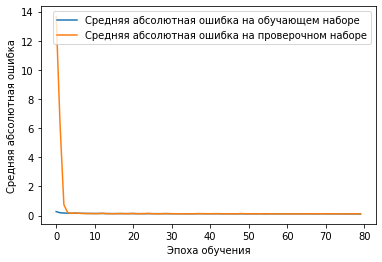

In [327]:
# запустим обучение модели на обновленных данных
model_simple3 = Sequential()
model_simple3.add(BatchNormalization(input_dim=train_features_scal3.shape[1]))
model_simple3.add(Dense(128, activation='relu'))
model_simple3.add(Dense(1000, activation='tanh'))
model_simple3.add(Dense(500, activation='relu'))
model_simple3.add(Dense(100, activation='relu'))
model_simple3.add(Dense(1, activation='linear'))

model_simple3.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

history = model_simple3.fit(train_features_scal3.astype('float32'), 
                    train_target_scaled, 
                    epochs=80, 
                    batch_size=256,
                    validation_split=0.15, 
                    verbose=1)

plot_history(history)

In [328]:
# Проверка работы сети - предсказание на тренировочной выборке
pred3 = model_simple3.predict(train_features_scal3.astype('float32'))

# Расчет среднего значения ошибки 
#print((abs(pred - train_target)).mean())         # Расчет вручную
print('MAE', mean_absolute_error(pred3, train_target_scaled))   # Расчет с помощью готовой функции
print('MSE', mean_squared_error(pred3, train_target_scaled))   # Расчет с помощью готовой функции
print('RMSE', mean_squared_error(pred3, train_target_scaled, squared=False))   # Расчет с помощью готовой функции

MAE 0.1036732366412514
MSE 0.059362474819165775
RMSE 0.24364415613588145


Средняя абсолютная ошибка: 64212.51824185635 

Реальное значение: 860000.00  Предсказанное значение: 936611.94  Разница: 76611.94
Реальное значение: 115000.00  Предсказанное значение: 86436.80  Разница: 28563.20
Реальное значение: 440000.00  Предсказанное значение: 521777.44  Разница: 81777.44
Реальное значение: 545000.00  Предсказанное значение: 519550.62  Разница: 25449.38
Реальное значение: 290000.00  Предсказанное значение: 212226.02  Разница: 77773.98
Реальное значение: 564999.00  Предсказанное значение: 554040.75  Разница: 10958.25
Реальное значение: 649000.00  Предсказанное значение: 613745.19  Разница: 35254.81
Реальное значение: 235000.00  Предсказанное значение: 274936.66  Разница: 39936.66
Реальное значение: 410000.00  Предсказанное значение: 317919.62  Разница: 92080.38
Реальное значение: 190000.00  Предсказанное значение: 159827.14  Разница: 30172.86


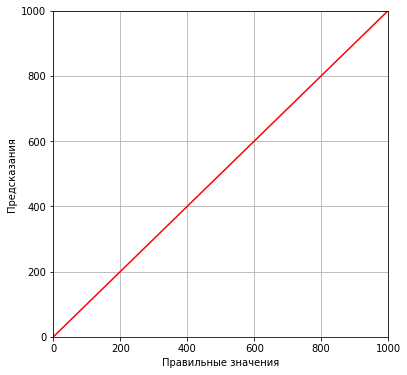

In [329]:
eval_net(model_simple3, train_features_scal3.astype('float32'), train_target.to_numpy().reshape(-1, 1), scaler)

In [330]:
# считаю среднюю цену машины на тестовой выборке
test_price_mean=test_target.mean()
test_price_mean

531536.2359653127

In [331]:
# считаю предсказания 3-й модели на тестовой выборке
pred_test_scaled3 = model_simple3.predict(test_features_scal3.astype('float32'))

In [332]:
MAE_scaled3=mean_absolute_error(pred_test_scaled3, test_target_scaled)
MAE_scaled3

0.12339375522972548

In [333]:
pred_unscaled3 = scaler.inverse_transform(pred_test_scaled3)

In [334]:
MAE_unscaled3=mean_absolute_error(pred_unscaled3, test_target)
MAE_unscaled3

79575.22117973407

In [335]:
# считаю суммарный процент ошибки = средний модуль ошибки (MAE) / среднюю цену машины.
result_unscaled3=MAE_unscaled3/test_price_mean
result_unscaled3

0.14970798940023167

Результаты улучшились, по сравнению со второй моделью. MAE уменьшилось с 0.14 до 0.12, суммарный процент ошибки понизился с 0.16 до 0.14. Видно, что мы на правильном пути

Попробуем поработать с текстом в колонке "model", создадим bag of words и embeddings

In [336]:
data_text = train_features_scal['model_full'].values #

len(data_text)

52581

In [337]:
# укажем размер словаря, инициализируем Токенайзер с соотв. параметрами, обработаем им нашу переменную data_text
maxWordsCount = 1300 

sim_for_del='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer (num_words=maxWordsCount, 
                       filters=sim_for_del, 
                       lower=True, 
                       split=' ', 
                       oov_token='unknown', 
                       char_level=False)

tokenizer.fit_on_texts(data_text)

In [338]:
# Переводим в Эмбеддинг пространство
Sequences = tokenizer.texts_to_sequences(data_text)

# Вариант  Bag of Words
xBOW_text = tokenizer.sequences_to_matrix(Sequences)

In [339]:
items = list(tokenizer.word_index.items())       # Получение индексов слов
print(items[:50])                                # Посмотр 50 самых часто встречающихся слов
print("Размер словаря", len(items))              # Длина словаря

[('unknown', 1), ('поколение', 2), ('рестайлинг', 3), ('1', 4), ('2', 5), ('3', 6), ('класс', 7), ('5', 8), ('серия', 9), ('focus', 10), ('astra', 11), ('nexia', 12), ('й', 13), ('4', 14), ('6', 15), ('octavia', 16), ('rio', 17), ('e', 18), ('lancer', 19), ('solaris', 20), ('logan', 21), ('passat', 22), ('h', 23), ('matiz', 24), ('7', 25), ('m150', 26), ('c', 27), ('niva', 28), ('family', 29), ('a6', 30), ('x', 31), ('a4', 32), ('200', 33), ('polo', 34), ('pajero', 35), ('cruze', 36), ('cx', 37), ('j300', 38), ('grand', 39), ('ix', 40), ('sportage', 41), ('s', 42), ('corolla', 43), ('308', 44), ('t7', 45), ('lacetti', 46), ('duster', 47), ('x5', 48), ('320', 49), ('v', 50)]
Размер словаря 1411


In [340]:
# Проверка получившихся данных
n = 0
print(data_text[n])                       # Профессия в тексте
print(Sequences[n])                        # Профессия в индексах слов
print(xBOW_text[n][0:100])          # Профессия в bag of words

c-класс 200 w204/s204/c204 [рестайлинг]
[27, 7, 33, 159, 160, 301, 3]
[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


Epoch 1/150
175/175 [==============================] - 1s 6ms/step - loss: 0.9747 - mae: 0.5496 - val_loss: 0.9493 - val_mae: 0.5308
Epoch 2/150
175/175 [==============================] - 1s 5ms/step - loss: 0.8665 - mae: 0.5018 - val_loss: 0.7814 - val_mae: 0.4483
Epoch 3/150
175/175 [==============================] - 1s 5ms/step - loss: 0.6706 - mae: 0.4011 - val_loss: 0.5719 - val_mae: 0.3478
Epoch 4/150
175/175 [==============================] - 1s 5ms/step - loss: 0.5077 - mae: 0.3236 - val_loss: 0.4503 - val_mae: 0.3194
Epoch 5/150
175/175 [==============================] - 1s 5ms/step - loss: 0.4050 - mae: 0.2764 - val_loss: 0.3637 - val_mae: 0.2692
Epoch 6/150
175/175 [==============================] - 1s 5ms/step - loss: 0.3423 - mae: 0.2471 - val_loss: 0.3136 - val_mae: 0.2358
Epoch 7/150
175/175 [==============================] - 1s 5ms/step - loss: 0.3036 - mae: 0.2285 - val_loss: 0.2871 - val_mae: 0.2235
Epoch 8/150
175/175 [==============================] - 1s 5ms/step - 

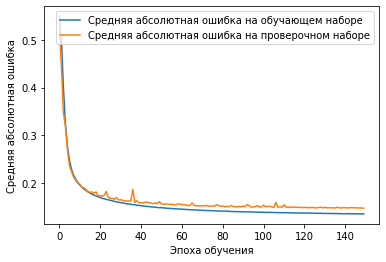

In [341]:

# Обучение модели на текстовых данных (bag of words)

model_prof = Sequential()
model_prof.add(Dense(20, activation='relu', input_dim=xBOW_text.shape[1]))
model_prof.add(Dense(500, activation='relu'))
model_prof.add(Dense(1, activation='linear'))

model_prof.compile(optimizer=Adagrad(learning_rate=1e-2), loss='mse', metrics=['mae'])

history = model_prof.fit(xBOW_text, 
                    train_target_scaled, 
                    batch_size=256,
                    epochs=150, 
                    validation_split=0.15, 
                    verbose=1)

plot_history(history)

Средняя абсолютная ошибка: 85460.90992060862 

Реальное значение: 860000.00  Предсказанное значение: 888498.69  Разница: 28498.69
Реальное значение: 115000.00  Предсказанное значение: 84265.67  Разница: 30734.33
Реальное значение: 440000.00  Предсказанное значение: 495716.00  Разница: 55716.00
Реальное значение: 545000.00  Предсказанное значение: 475664.91  Разница: 69335.09
Реальное значение: 290000.00  Предсказанное значение: 207440.52  Разница: 82559.48
Реальное значение: 564999.00  Предсказанное значение: 389870.19  Разница: 175128.81
Реальное значение: 649000.00  Предсказанное значение: 745773.19  Разница: 96773.19
Реальное значение: 235000.00  Предсказанное значение: 139754.23  Разница: 95245.77
Реальное значение: 410000.00  Предсказанное значение: 423208.12  Разница: 13208.12
Реальное значение: 190000.00  Предсказанное значение: 132996.36  Разница: 57003.64


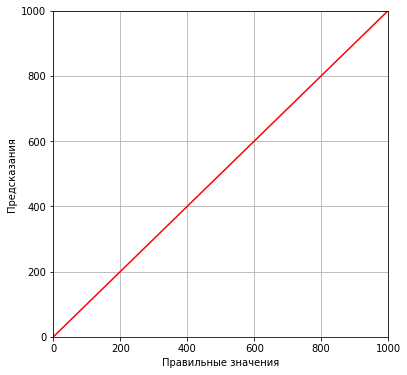

In [342]:
eval_net(model_prof, xBOW_text, train_target.to_numpy().reshape(-1, 1), scaler)

In [343]:
data_text_test = test_features_scal['model_full'].values #

len(data_text_test)
tokenizer.fit_on_texts(data_text_test)
# Переводим в Эмбеддинг пространство
Sequences_test = tokenizer.texts_to_sequences(data_text_test)

# Вариант  Bag of Words
xBOW_text_test = tokenizer.sequences_to_matrix(Sequences_test)

In [344]:
# считаю предсказания 3-й модели на тестовой выборке
pred_test_scaled4 = model_prof.predict(xBOW_text_test)
MAE_scaled4=mean_absolute_error(pred_test_scaled4, test_target_scaled)
print('MAE нормир', MAE_scaled4)


MAE нормир 0.7363905165050971


In [345]:
pred_unscaled4 = scaler.inverse_transform(pred_test_scaled4)


In [346]:
# считаю суммарный процент ошибки = средний модуль ошибки (MAE) / среднюю цену машины.
MAE_unscaled4=mean_absolute_error(pred_unscaled4, test_target)
print('MAE ненормир', MAE_unscaled4)


MAE ненормир 474889.8175856966


In [347]:
result_unscaled4=MAE_unscaled4/test_price_mean
print('суммарный процент ошибки 4 модели', result_unscaled4)

суммарный процент ошибки 4 модели 0.8934288679740872


Скажем так, 4 модель не улучшила показатели. 

В финальной части мы создадим сложную нелинейную архитектуру нейронной сети. Мы создадим модель, у которой будет два входных набора данных:

- числовой набор (это наша третья выборка)
- текстовый набор (набор, содержащий информацию о моделях)

In [348]:
input1 = Input((train_features_scal3.astype('float32').shape[1],))
input2 = Input((xBOW_text.shape[1],))


x1 = input1                               # Ветка 1
x1 = Dense(128, activation="relu")(x1)
x1 = Dense(1000, activation="tanh")(x1)
x1 = Dense(100, activation="relu")(x1)

x2 = input2                               # Ветка 2
x2 = Dense(20, activation="relu")(x2)
x2 = Dense(500, activation="relu")(x2)
x2 = Dropout(0.3)(x2)



x = concatenate([x1, x2])             # Объединение двух веток

x = Dense(15, activation='relu')(x)       # Промежуточный слой
x = Dropout(0.5)(x)
x = Dense(1, activation='linear')(x)      # Финальный регрессирующий нейрон

# В Model передаются входы и выход
model_final = Model((input1, input2), x)

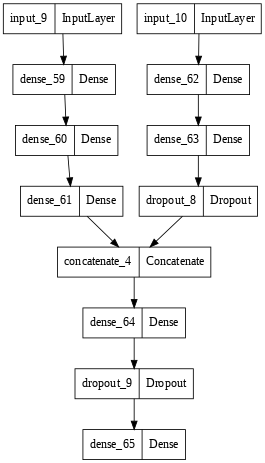

In [349]:
utils.plot_model(model_final, dpi=60)

In [350]:
model_final.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

history = model_final.fit([train_features_scal3.astype('float32'), xBOW_text], 
                           train_target_scaled,
                           batch_size=256, 
                           epochs=50, 
                           validation_split=0.15,
                           verbose=1)

Epoch 1/50
175/175 [==============================] - 2s 9ms/step - loss: 1.0062 - mae: 0.5632 - val_loss: 1.0105 - val_mae: 0.5554
Epoch 2/50
175/175 [==============================] - 1s 7ms/step - loss: 0.9982 - mae: 0.5604 - val_loss: 1.0105 - val_mae: 0.5547
Epoch 3/50
175/175 [==============================] - 1s 7ms/step - loss: 0.9982 - mae: 0.5600 - val_loss: 1.0105 - val_mae: 0.5550
Epoch 4/50
175/175 [==============================] - 1s 7ms/step - loss: 0.9982 - mae: 0.5607 - val_loss: 1.0105 - val_mae: 0.5549
Epoch 5/50
175/175 [==============================] - 1s 7ms/step - loss: 0.9982 - mae: 0.5596 - val_loss: 1.0105 - val_mae: 0.5552
Epoch 6/50
175/175 [==============================] - 1s 7ms/step - loss: 0.9982 - mae: 0.5605 - val_loss: 1.0105 - val_mae: 0.5553
Epoch 7/50
175/175 [==============================] - 1s 7ms/step - loss: 0.9982 - mae: 0.5596 - val_loss: 1.0105 - val_mae: 0.5557
Epoch 8/50
175/175 [==============================] - 1s 7ms/step - loss: 0.

Средняя абсолютная ошибка: 347629.78838839126 

Реальное значение: 860000.00  Предсказанное значение: 533059.75  Разница: 326940.25
Реальное значение: 115000.00  Предсказанное значение: 533059.75  Разница: 418059.75
Реальное значение: 440000.00  Предсказанное значение: 533059.75  Разница: 93059.75
Реальное значение: 545000.00  Предсказанное значение: 533059.75  Разница: 11940.25
Реальное значение: 290000.00  Предсказанное значение: 533059.75  Разница: 243059.75
Реальное значение: 564999.00  Предсказанное значение: 533059.75  Разница: 31939.25
Реальное значение: 649000.00  Предсказанное значение: 533059.75  Разница: 115940.25
Реальное значение: 235000.00  Предсказанное значение: 533059.75  Разница: 298059.75
Реальное значение: 410000.00  Предсказанное значение: 533059.75  Разница: 123059.75
Реальное значение: 190000.00  Предсказанное значение: 533059.75  Разница: 343059.75


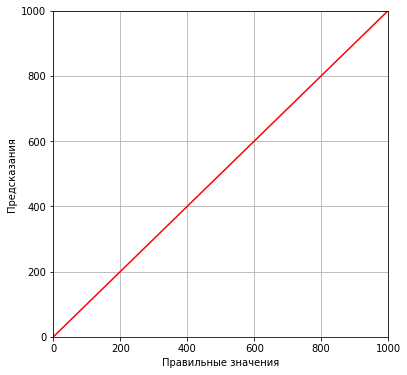

In [351]:
eval_net(model_final, [train_features_scal3.astype('float32'), xBOW_text], train_target.to_numpy().reshape(-1, 1), scaler)
#eval_net(model_prof, xBOW_text, train_target.to_numpy().reshape(-1, 1), scaler)

К сожалению, и этот эксперимент не улучшил результаты 3-й модели. Можно было бы еще продолжить эксперименты со структурой третьей модели, постараться улучшить  среднюю ошибку, но оставим это на другой раз ))
